In [1]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/matsumotoyuka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/matsumotoyuka/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [29]:
# Excelファイルの読み込み
excel_file_path = 'all_data.xlsx'
csv_file_path = 'all_data.csv'
df = pd.read_excel(excel_file_path, sheet_name=0)

# 条件に合うデータを削除
# '場所'が'橘湾'または'舘山'で、かつlabelが0のデータを削除
df = df[~((df['場所'].isin(['橘湾', '舘山'])) & (df['label'] == 0))]

# 削除する列のリスト
columns_to_drop = ['Density [kg/m^3]', '緯度', '経度', 'DO eq', '備考', '水深', 'pH', 'Pressure',
                  'O2 weiss 1970', 'DIC[μmol/L@25℃]', 'Depth[m]', 'DO[ µmol/kg]',
                  'TA [μmol/kg]', 'Salinity', '日時', '場所', 'No.']

# 指定された列を削除
df.drop(columns=columns_to_drop, inplace=True)

df = df[df['label'] != -1]

# CSVファイルとして保存
df.to_csv(csv_file_path, index=False)
print(f"CSVファイルが保存されました: {csv_file_path}")
df

CSVファイルが保存されました: all_data.csv


,pCO2,AOU,excess DIC,T,nDIC+0.768DO,DIC-0.5TA+0.83DO,DO Saturation,label
18,609.054405,5.103117,65.754199,26.1010,2234.610383,1053.148478,0.975200,1
135,564.930029,12.868835,49.888406,18.0400,2285.756471,1132.068050,0.945459,1
136,566.704024,16.336327,50.400634,18.0700,2283.360541,1129.289180,0.930744,1
137,569.721742,8.624603,51.355938,18.2300,2288.770308,1135.138190,0.963304,1
138,568.501477,12.060292,50.985970,18.1700,2286.217390,1132.425550,0.948760,1
...,...,...,...,...,...,...,...,...
2060,542.771000,118.587515,49.811000,10.6016,2265.132400,1143.534000,0.521004,0
2061,557.977000,130.831224,53.484000,10.1420,2265.232200,1141.832000,0.483192,0
2062,519.493000,119.491733,43.128000,10.7688,2255.845200,1134.107000,0.516312,0
2063,538.981000,128.104189,48.153000,10.0288,2263.360400,1140.654000,0.493668,0


Performing parameter tuning...

Results for all kernels:
    kernel     nu  accuracy  precision    recall        f1  num_anomalies
0      rbf  0.015  0.975095   0.178571  0.178571  0.178571             28
1   linear  0.015  0.680022   0.042276  0.928571  0.080871            615
2     poly  0.015  0.938278   0.109091  0.428571  0.173913            110
3  sigmoid  0.015  0.971846   0.038462  0.035714  0.037037             26

Best parameters:
kernel: rbf
accuracy: 0.975
accuracy: 0.179
accuracy: 0.179
accuracy: 0.179
detected anomalies: 28


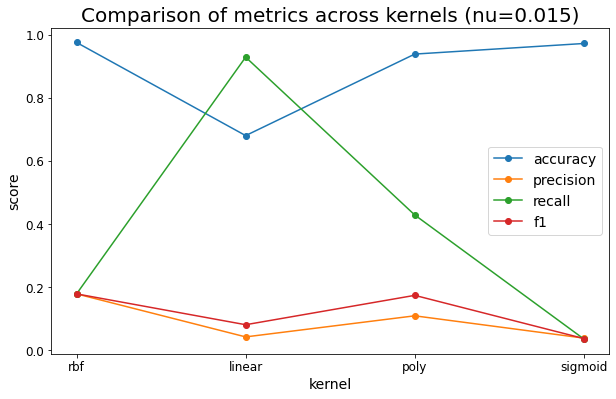

In [34]:
def evaluate_ocsvm(X, y_true, kernel, nu=0.015):
    """
    One Class SVMモデルを評価する関数

    Parameters:
    -----------
    X : array-like
        特徴量データ
    y_true : array-like
        実際のラベル (0: 正常, 1: 異常)
    kernel : str
        カーネル関数の種類
    nu : float
        異常値の割合 (0.1に固定)

    Returns:
    --------
    dict : 評価指標の辞書
    """
    # One Class SVMモデルの作成と予測
    ocsvm = OneClassSVM(kernel=kernel, gamma='scale', nu=nu)  # gammaを'scale'に固定

    # 予測（1: 正常, -1: 異常 が返される）
    y_pred = ocsvm.fit_predict(X)

    # -1, 1 を 1, 0 に変換（1:異常, 0:正常）
    y_pred = np.where(y_pred == -1, 1, 0)
    num_anomalies = np.sum(y_pred == 1)

    # 評価指標の計算
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'num_anomalies': num_anomalies
    }

    return metrics

def parameter_tuning(X, y_true):
    """
    異なるカーネルでOne Class SVMを評価する関数

    Parameters:
    -----------
    X : array-like
        特徴量データ
    y_true : array-like
        実際のラベル
    """
    # kernelのみパラメータとして設定
    kernels = ['rbf', 'linear', 'poly', 'sigmoid']
    nu = 0.015

    results = []

    for kernel in kernels:
        metrics = evaluate_ocsvm(X, y_true, kernel=kernel, nu=nu)
        results.append({
            'kernel': kernel,
            'nu': nu,
            **metrics
        })

    return pd.DataFrame(results)

def plot_results(results):
    """
    パラメータチューニングの結果をプロットする関数

    Parameters:
    -----------
    results : pandas.DataFrame
        パラメータチューニングの結果
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    for metric in metrics:
        ax.plot(results['kernel'],
                results[metric],
                marker='o',
                label=metric)

    ax.set_xlabel('kernel', fontsize=14)
    ax.set_ylabel('score', fontsize=14)
    ax.set_title('Comparison of metrics across kernels (nu=0.015)', fontsize=20)
    ax.legend(fontsize=14)
    ax.grid(False)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    return fig

def main(df):
    """
    メイン処理を実行する関数

    Parameters:
    -----------
    df : pandas.DataFrame
        特徴量とラベル('label')を含むデータフレーム
    """
    # 特徴量とラベルを分離
    X = df.drop('label', axis=1)
    y = df['label']

    # データの標準化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # パラメータチューニング
    print("Performing parameter tuning...")
    results = parameter_tuning(X_scaled, y)

    # 結果の表示
    print("\nResults for all kernels:")
    print(results)

    # 最良の結果を表示
    best_result = results.loc[results['accuracy'].idxmax()]
    print("\nBest parameters:")
    print(f"kernel: {best_result['kernel']}")
    print(f"accuracy: {best_result['accuracy']:.3f}")
    print(f"accuracy: {best_result['precision']:.3f}")
    print(f"accuracy: {best_result['recall']:.3f}")
    print(f"accuracy: {best_result['f1']:.3f}")
    print(f"detected anomalies: {best_result['num_anomalies']}")

    # 結果をプロット
    fig = plot_results(results)

    return results, fig

results, fig = main(df)
plt.show()

In [33]:
###生データ

# Excelファイルの読み込み
excel_file_path = 'all_data.xlsx'
csv_file_path = 'all_data.csv'
df = pd.read_excel(excel_file_path, sheet_name=0)

df = df[df['label'] != -1]

# 削除する列のリスト
columns_to_drop = ['水深','Density [kg/m^3]', '緯度', '経度', 'DO eq', '備考', 'pH', 'Pressure',
                  'O2 weiss 1970', '日時', '場所', 'No.', 'Depth[m]', 'Salinity', 'AOU', 'excess DIC', 'nDIC+0.768DO','DIC-0.5TA+0.83DO', 'DO Saturation']

# 指定された列を削除
df.drop(columns=columns_to_drop, inplace=True)

# CSVファイルとして保存
df.to_csv(csv_file_path, index=False)
print(f"CSVファイルが保存されました: {csv_file_path}")
df

CSVファイルが保存されました: all_data.csv


,pCO2,T,TA [μmol/kg],DO[ µmol/kg],DIC[μmol/L@25℃],label
18,609.054405,26.1010,2153.3,201.181294,1962.818004,1
135,564.930029,18.0400,2230.0,223.335000,2061.700000,1
136,566.704024,18.0700,2229.6,219.746000,2061.700000,1
137,569.721742,18.2300,2229.6,226.793000,2061.700000,1
138,568.501477,18.1700,2229.7,223.585000,2061.700000,1
...,...,...,...,...,...,...
2060,542.771000,10.6016,2325.8,149.800000,2182.100000,0
2061,557.977000,10.1420,2322.4,140.400000,2186.500000,0
2062,519.493000,10.7688,2326.1,147.900000,2174.400000,0
2063,538.981000,10.0288,2323.8,143.800000,2183.200000,0
